# Hazard: Landslides

The `landslide` class inherits from the `hazard` class. Other than some of the hazard modules available in `climada`, the landslide module does not run a physical model in its background. Rather, this tutorial is a suggestion of how to handle two different types of hazard source files (in one case, already the finished product of some model output, in the other case just a historic data collection).

We propose 2 different types of landslide hazard datasets that the module's methods work well with: 
* *historic landslides*: historic event sets based on the NASA COOLR global landslide catalogue, continuously updated.
* *probabilistic landslides*: two raster files on probabilistic LS hazard, one for landslides triggered by precipitation and one for landslides triggered by earthquakes, based on data from the Norwegian Geotechnical Institute (NGI) for UNEP GRID, last improved 2018.

The module comes with two main functions, both delivering a raster-hazard set (once of historic occurrences, once with probabilistically sampled occurrences)
* `from_hist()`
* `from_prob()`

### Option 1: historic landslide events: NASA COOLR initiative
Data from the global landslide catalogue is continuously updated as part of the Cooperative Open Online Landslide Repository (https://pmm.nasa.gov/landslides/coolrdata.html#download). The data consists in points representing an approximate occurence location, without spatial extent and any kind of "intensity" (binary events).

The most recent version of the dataset should always be downloaded by going to the link > "Open Landslide Viewer" (takes some time to load) > click "Download the full Landslide Catalog" > selecting the "NASA Global Landslide Catalog Points (Shapefile)" for download.

Download and unzip the up-to-date version.

Put it into the 
**Important**: The original file has a typo in one of its entries, which messes up the reading of a bounding box. Reading it once into memory with geopandas and re-saving it as shapefile solves this. This has to be done only once.


In [7]:
# Amending the Landslide catalog by loading and re-saving (only necessary first time!)
import geopandas as gpd

# replace with your path to file nasa_global_landslide_catalog_point.shp if not in ~/climada/data folder
PATH_COOLR = str(CONFIG.local_data.system.dir()) + '/haz/nasa_global_landslide_catalog_point/nasa_global_landslide_catalog_point.shp'
ls_gdf_all = gpd.read_file(PATH_COOLR)
ls_gdf_all.to_file(PATH_COOLR)

Now we can start the actual task..

In [8]:
# Loading packages and constants
%matplotlib inline
from climada_petals.hazard.landslide import Landslide
from climada import CONFIG
# replace with your path to file nasa_global_landslide_catalog_point.shp if not in ~/climada/data folder
PATH_COOLR = str(CONFIG.local_data.system.dir()) + '/haz/nasa_global_landslide_catalog_point/nasa_global_landslide_catalog_point.shp'

The historic landslide events are read into a landslide hazard set.
Since the events are reported as simple points, we convert the hazard set to a raster file with a certain resolution.

**Important note on projections and resolution**
The resolution is up to your choice and has implications: The grid which is generated has the same projection and units as the input geodataframe with point landslide occurrences. By default, this is EPSG:4326, which is a non-projected, geographic CRS. This means, depending on where on the globe the analysis is performed, the area per gridcell differs vastly. Consider this when setting your resoluton (e.g. at the equator, 1° ~ 111 km). In turn, one can use a projected CRS which preserve angles and areas within the reference area for which they are defined. To do this, reproject the input_gdf to the desired projection. For more on projected & geographic CRS, read [here](https://desktop.arcgis.com/en/arcmap/10.3/guide-books/map-projections/about-projected-coordinate-systems.htm)
        
Here, we will stick with the default geopgraphic (non-projected) EPSG 4326 and take a resolution of 0.004° (which is about 450m at the equator).
All area within a grid cell that "hosts" an event point is hence affected.

2022-05-09 11:00:42,954 - climada_petals.hazard.landslide - INFO - Reading in gdf from source /Users/evelynm/climada/data/nasa_global_landslide_catalog_point/nasa_global_landslide_catalog_point.shp
2022-05-09 11:00:43,058 - climada_petals.hazard.landslide - INFO - Generating a raster with resolution 0.004 for box (120.0, 21.5, 122.0, 25.5)


/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/pyproj/crs/crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)


<GeoAxesSubplot:title={'center':'LS max intensity at each point'}>

/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


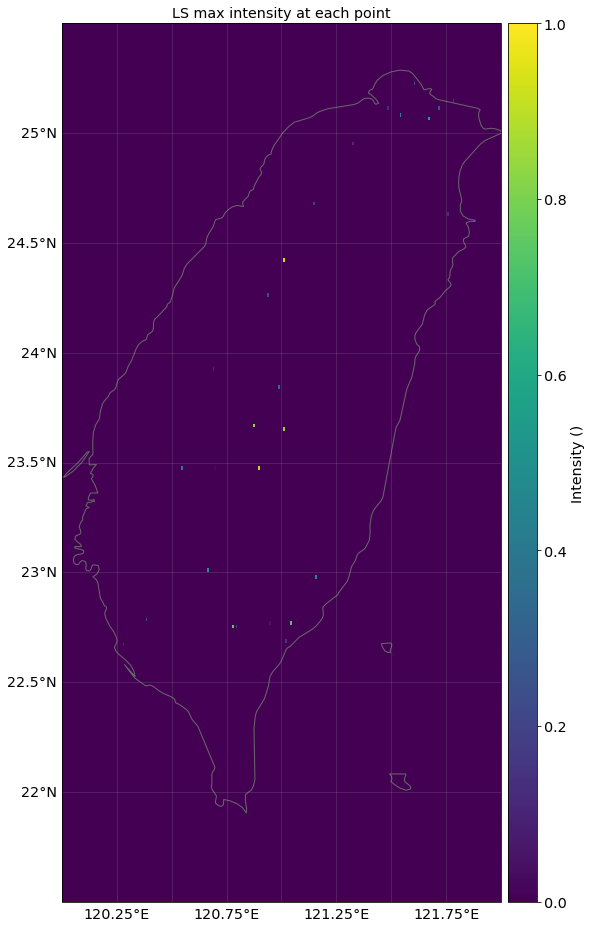

In [9]:
bbox_taiwan = (120.0, 21.5, 122.0, 25.5) # bbox as (minx, miny, maxx, maxy) 
# Example for Taiwan
haz_ls_Taiwan_hist = Landslide.from_hist(bbox=bbox_taiwan, input_gdf=PATH_COOLR, res=0.004)
# Visual inspection of the hazard
haz_ls_Taiwan_hist.plot_intensity(0)

### Exemplary end-to-end impact calculation using the historic LS option

The steps below follow the normal routine of defining impact functions, getting an exposure, and performing an impact calculation based on the given historic hazard set.

*Impact functions* relate the hazard intensity to a percentage of damage in the exposure. For a detailed description on impact functions, check out the respective tutorial.

Since the historic landslides are binary (occurrence / non-occurrence), their intensity is simply put to "1" at the respective grid-point where one occurred. A dummy step impact function is created for illustrative purposes, where damage (impact) is simply 100% when intensity is (close to) 1, and 0 else.

In [13]:
from climada.entity.exposures import LitPop
from climada.entity.entity_def import Entity
from climada.entity import ImpactFuncSet, ImpactFunc
from climada.engine import Impact
import numpy as np

2022-04-11 15:11:37,339 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.


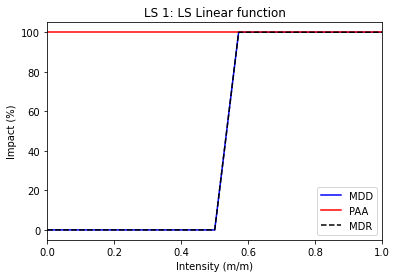

In [14]:
# Set impact function (see tutorial climada_entity_ImpactFuncSet)
impf_LS_hist = ImpactFunc() 
impf_LS_hist.haz_type = 'LS'
impf_LS_hist.id = 1
impf_LS_hist.name = 'LS Linear function'
impf_LS_hist.intensity_unit = 'm/m'
impf_LS_hist.intensity = np.linspace(0, 1, num=15)
impf_LS_hist.mdd = np.sort(np.array([0,0,0,0,0,0,0,0,1., 1., 1., 1., 1., 1., 1.]))
impf_LS_hist.paa = np.sort(np.linspace(1, 1, num=15))
impf_LS_hist.check()
impf_LS_hist.plot()
ifset_LS_hist = ImpactFuncSet()
ifset_LS_hist.append(impf_LS_hist)

For a detailed description of the *Exposure* class, refer to the respective tutorial.
This LS tutorial uses the LitPop class, which models countries' gridded asset exposure by disaggregating a macroeconomic indicator (e.g. total asset value or GDP) proportional to the product of night light intensities ("Lit") and gridded population count ("Pop") per country.  

2022-04-11 15:11:43,471 - climada.entity.exposures.litpop.litpop - INFO - 
 LitPop: Init Exposure for country: TWN (158)...

2022-04-11 15:11:43,475 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2022-04-11 15:11:43,527 - climada.entity.exposures.litpop.gpw_population - INFO - GPW Version v4.11


/Users/evelynm/climada_python/climada/entity/exposures/litpop/litpop.py:607: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for idx, polygon in enumerate(list(country_geometry)):
/Users/evelynm/climada_python/climada/entity/exposures/litpop/litpop.py:607: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for idx, polygon in enumerate(list(country_geometry)):


2022-04-11 15:11:44,320 - climada.util.finance - WARNING - No data available for country. Using non-financial wealth instead
2022-04-11 15:11:44,321 - climada.util.finance - WARNING - GDP data for TWN is not provided by World Bank.                        Instead, IMF data is returned here.
2022-04-11 15:11:44,350 - climada.entity.exposures.base - INFO - Hazard type not set in impf_
2022-04-11 15:11:44,351 - climada.entity.exposures.base - INFO - category_id not set.
2022-04-11 15:11:44,351 - climada.entity.exposures.base - INFO - cover not set.
2022-04-11 15:11:44,352 - climada.entity.exposures.base - INFO - deductible not set.
2022-04-11 15:11:44,352 - climada.entity.exposures.base - INFO - centr_ not set.
2022-04-11 15:11:44,354 - climada.util.coordinates - INFO - Setting geometry points.
2022-04-11 15:11:44,378 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2022-04-11 15:11:44,389 - climada.entity.exposures.base - INFO - category_id not set.
2022

/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/pyproj/crs/crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/contextily/tile.py:265: FutureWarning: The url format using 'tileX', 'tileY', 'tileZ' as placeholders is deprecated. Please use '{x}', '{y}', '{z}' instead.
  warnings.warn(


2022-04-11 15:11:59,465 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


<GeoAxesSubplot:title={'center':"LitPop Exposure for ['Taiwan'] at 30 as, year: 2018, financial mode:\npc, exp: (1, 1), admin1_calc: False"}>

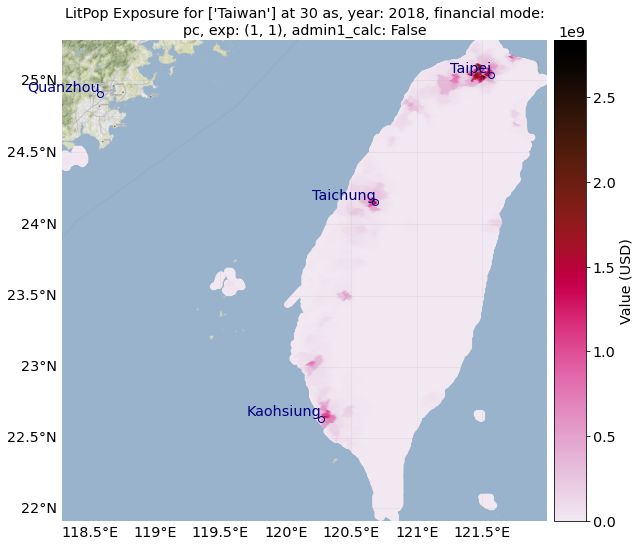

In [15]:
# Set LitPop exposure for Taiwan
exp_LS_hist = LitPop.from_countries(['Taiwan'])
exp_LS_hist.set_geometry_points()
exp_LS_hist.gdf.rename({'impf_': 'impf_LS'}, axis='columns',inplace=True)
exp_LS_hist.set_lat_lon()
exp_LS_hist.check()

# plot the exposure
exp_LS_hist.plot_basemap()

In [16]:
# Set Entity    
ent_LS_hist = Entity()
ent_LS_hist.exposures = exp_LS_hist
ent_LS_hist.impact_funcs = ifset_LS_hist

**Important note**:  Climada allows you to perform damage statistics (such as average annual impact, impact exceedance curves, etc.). Since those reported events have no guarantee of completeness, and cover a relatively short time, it is strongly advised **not** to perform such calculations. Since fr For `impact.at_event` in turn, no frequency correction is made. Apply the probabilistic method (explained below) for such calculations. 

2022-04-11 15:12:01,829 - climada.entity.exposures.base - INFO - Matching 46167 exposures with 501501 centroids.
2022-04-11 15:12:01,835 - climada.engine.impact - INFO - Calculating damage for 45512 assets (>0) and 73 events.
2022-04-11 15:12:01,853 - climada.util.coordinates - INFO - Raster from resolution 0.008333329999956618 to 0.008333329999956618.


/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/pyproj/crs/crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for

The overall estimated impact from all events is 115515445 $


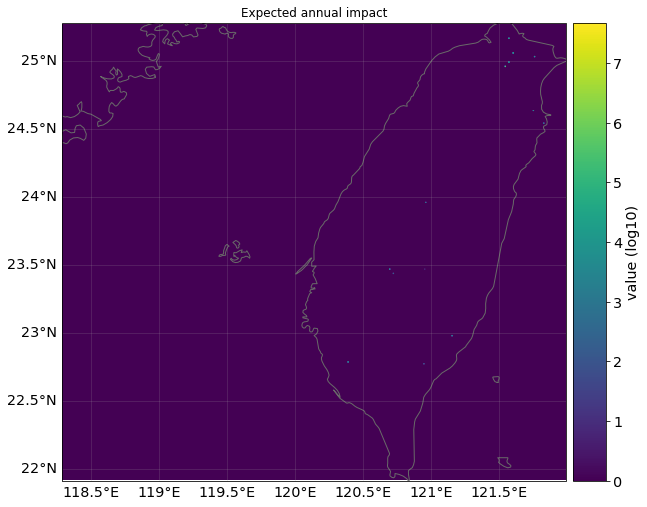

In [17]:
# Impact calculation from historic landslides, with exposure and impact function defined as above.
imp_LS_Taiwan_hist = Impact()
imp_LS_Taiwan_hist.calc(ent_LS_hist.exposures, ent_LS_hist.impact_funcs, haz_ls_Taiwan_hist)
imp_LS_Taiwan_hist.plot_raster_eai_exposure()
print(f'The overall estimated impact from all events is {int(imp_LS_Taiwan_hist.aai_agg)} $')

### Option 2:  probabilistic landslide hazard (precipitation / earthquake-induced) from UNEP / NGI

The global probabilistic hazardsets are provided publicly by UNEP GRID and were developed by the Norwegian Geotechnical Institute (NGI).

Since the webservices are currently (as of 08/20) not working, please download the geoTIFFs manually:

- Go to https://preview.grid.unep.ch/index.php?preview=data&events=landslides&evcat=2&lang=eng for precipitation-triggered landslides.
- Go to https://preview.grid.unep.ch/index.php?preview=data&events=landslides&evcat=1&lang=eng for earthquake-triggered landslides.
- Unzip the folder and move it to a sensible location


The datasets are in units of expected annual probability and percentage of pixel of occurrence of a potentially destructive landslide event x 1000000 and include an estimate of the annual frequency of landslide triggered by precipitation / earthquakes. It depends on the combination of trigger and susceptibility defined by six parameters: slope factor, lithological (or geological) conditions, soil moisture condition, vegetation cover, precipitation and seismic conditions.

Discrete events are produced by sampling over the occurrence probabilities in each grid cell. The user has the option to choose either a binomial or a Poisson distribution via the `dist` kwarg.
Since occurrence probabilities are given annually, an event represents a year of sampled landslide occurrences in the area.

Read the documentation for details. 

In [14]:
# Loading packages and setting constants
%matplotlib inline
from climada_petals.hazard.landslide import Landslide
# replace with your path to file ls_pr.tif if not in ~/climada/data folder
PATH_LSPROB = str(CONFIG.local_data.system.dir()) + '/haz/ls_pr/ls_pr.tif'

Let's produce a 500 year probabilistic event set for the same geographic extent as above.
Be aware that the resolution of the grid cells is 0.00833° (about 900m at the equator), so events tend to be quite large, if they occur.

2022-05-09 11:03:36,319 - climada.util.coordinates - INFO - Reading /Users/evelynm/climada/data/haz/ls_pr/ls_pr.tif
2022-05-09 11:03:38,259 - climada.hazard.centroids.centr - INFO - Convert centroids to GeoSeries of Point shapes.


/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/pyproj/crs/crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)


<GeoAxesSubplot:title={'center':'LS max intensity at each point'}>

/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


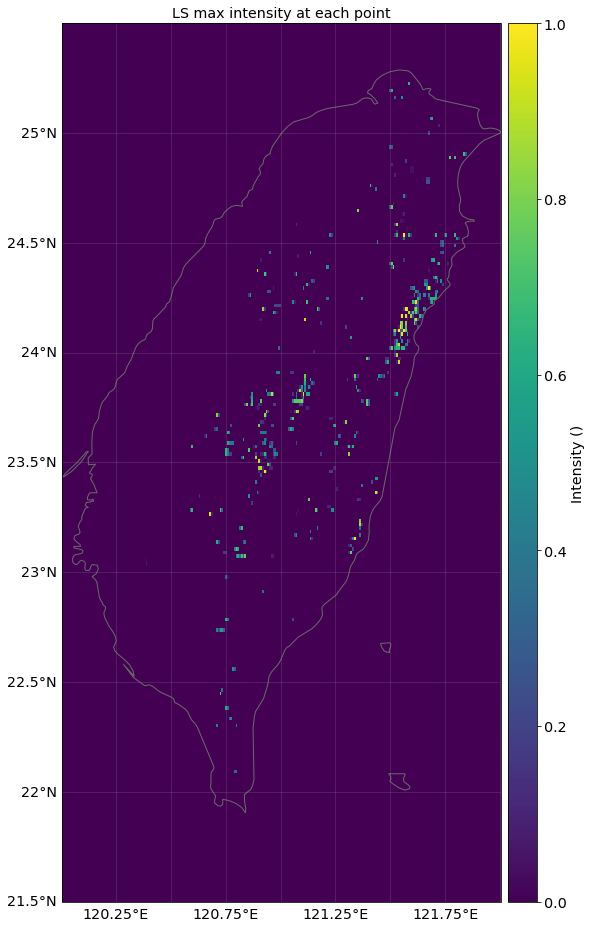

In [15]:
# Setting precipitation-triggered landslide hazard for Taiwan
bbox_taiwan = (120.0, 21.5, 122.0, 25.5)

# The check-plots produce intensity (image 1) and fraction (image 2) plots
# a correction factor of 1 million is applied since probs are reportet as x10e6 in the original data:
haz_ls_taiwan_prob =  Landslide.from_prob(bbox=bbox_taiwan, path_sourcefile=PATH_LSPROB, 
                                           n_years=500, corr_fact=10e6, dist='poisson')
# Visual inspection of the hazard
haz_ls_taiwan_prob.plot_intensity(0)

With the hazard set loaded, it is now possible to calculate the expected damage for the simulated period:

In [16]:
from climada.entity import LitPop
from climada.entity.entity_def import Entity
from climada.entity import ImpactFuncSet, ImpactFunc
from climada.engine import Impact
import numpy as np

**Important for impact calculations**: Since impact functions act on the intensity of a hazard, an our hazard takes on binary intensity values (0 = no LS prob, 1 = >0 LS prob), it makes sense to define some step-function around those two values. The impact calculation accounts for the fractions (% of affected pixel and actual annual probability) by multiplying them into the end-result, anyways, under the hood.

2022-05-09 11:04:17,672 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.


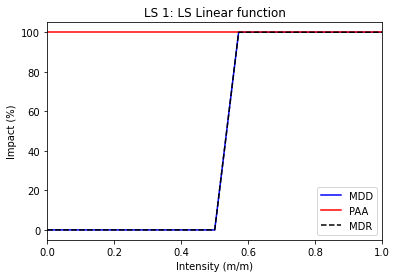

In [17]:
# Set impact function
impf_LS_prob = ImpactFunc() 
impf_LS_prob.haz_type = 'LS'
impf_LS_prob.id = 1
impf_LS_prob.name = 'LS Linear function'
impf_LS_prob.intensity_unit = 'm/m'
impf_LS_prob.intensity = np.linspace(0, 1, num=15)
impf_LS_prob.mdd = np.sort(np.array([0,0,0,0,0,0,0,0,1., 1., 1., 1., 1., 1., 1.]))
impf_LS_prob.paa = np.sort(np.linspace(1, 1, num=15))
impf_LS_prob.check()
impf_LS_prob.plot()
impf_set_LS_prob = ImpactFuncSet()
impf_set_LS_prob.append(impf_LS_prob)

In [22]:
# Set exposure for Taiwan:
exp_LS_prob = LitPop.from_countries(['Taiwan'])
exp_LS_prob.set_geometry_points()
exp_LS_prob.gdf.rename({'impf_': 'impf_LS'}, axis='columns', inplace=True)
exp_LS_prob.set_lat_lon()
exp_LS_prob.check()

2022-05-09 11:04:47,143 - climada.entity.exposures.litpop.litpop - INFO - 
 LitPop: Init Exposure for country: TWN (158)...

2022-05-09 11:04:47,144 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2022-05-09 11:04:47,146 - climada.entity.exposures.litpop.gpw_population - INFO - GPW Version v4.11


/Users/evelynm/climada_python/climada/entity/exposures/litpop/litpop.py:607: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for idx, polygon in enumerate(list(country_geometry)):
/Users/evelynm/climada_python/climada/entity/exposures/litpop/litpop.py:607: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for idx, polygon in enumerate(list(country_geometry)):


2022-05-09 11:04:47,847 - climada.util.finance - WARNING - No data available for country. Using non-financial wealth instead
2022-05-09 11:04:47,848 - climada.util.finance - WARNING - GDP data for TWN is not provided by World Bank.                        Instead, IMF data is returned here.
2022-05-09 11:04:47,878 - climada.entity.exposures.base - INFO - Hazard type not set in impf_
2022-05-09 11:04:47,879 - climada.entity.exposures.base - INFO - category_id not set.
2022-05-09 11:04:47,879 - climada.entity.exposures.base - INFO - cover not set.
2022-05-09 11:04:47,880 - climada.entity.exposures.base - INFO - deductible not set.
2022-05-09 11:04:47,881 - climada.entity.exposures.base - INFO - centr_ not set.
2022-05-09 11:04:47,883 - climada.util.coordinates - INFO - Setting geometry points.
2022-05-09 11:04:47,906 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2022-05-09 11:04:47,917 - climada.entity.exposures.base - INFO - category_id not set.
2022

In [19]:
# Set Entity    
ent_LS_prob = Entity()
ent_LS_prob.exposures = exp_LS_prob
ent_LS_prob.impact_funcs = impf_set_LS_prob

2022-05-09 11:05:29,631 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LS
2022-05-09 11:05:29,635 - climada.engine.impact - INFO - Calculating damage for 45512 assets (>0) and 500 events.
2022-05-09 11:05:29,652 - climada.util.coordinates - INFO - Raster from resolution 0.008333329999956618 to 0.008333329999956618.


/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/pyproj/crs/crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for

<GeoAxesSubplot:title={'center':'Expected annual impact'}>

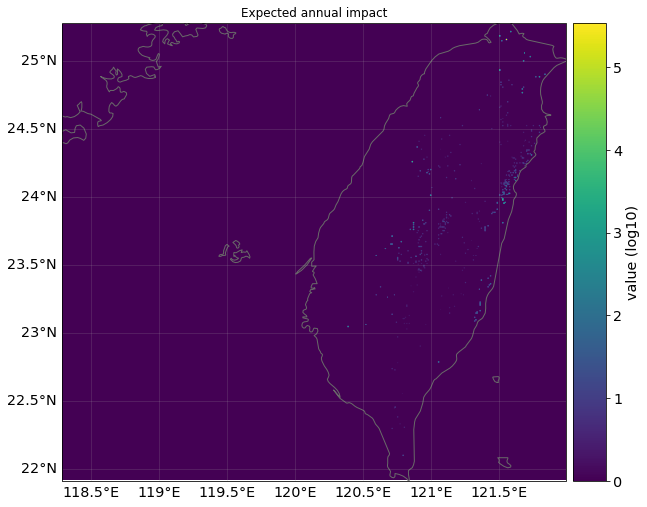

In [23]:
# Set impact for probabilistic simulation
imp_LS_Taiwan_prob = Impact()
imp_LS_Taiwan_prob.calc(ent_LS_prob.exposures, ent_LS_prob.impact_funcs, haz_ls_taiwan_prob)
imp_LS_Taiwan_prob.plot_raster_eai_exposure()

In [24]:
imp_LS_Taiwan_prob.aai_agg

1508057.2027470088